# Aaron Kohn
## Final Project; Universal Parks Ratings

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import nltk
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,  precision_recall_fscore_support, accuracy_score
from yellowbrick.text.freqdist import FreqDistVisualizer


In [3]:
# Load data
universal_df = pd.read_csv('universal_studio_branches.csv')

In [4]:
# View data
universal_df.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [5]:
# Check for duplicates
print(sum(universal_df.duplicated(subset = ['review_text', 'rating']))) # Get some of duplicates reviews and ratings
universal_df.drop_duplicates(subset = ['review_text', 'rating'], inplace=True) # Drop duplicates
print(sum(universal_df.duplicated(subset = ['review_text']))) # Check for duplicate review text with different ratings
print(sum(universal_df.duplicated())) # Check for completely duplicate rows

universal_df.drop(['reviewer'], axis=1, inplace=True) # Drop reviewr names

55
2
0


In [6]:
universal_df[universal_df.duplicated(subset = ['review_text'], keep= False)] # View duplicated reviews with different ratings

,rating,written_date,title,review_text,branch
3087,3.0,"February 13, 2019","Harry Potter area is A+, Mummy is A, all else ...","Harry Potter area is A+, Mummy is A, all else ...",Universal Studios Florida
10866,2.0,"March 13, 2017","Harry Potter area is A+, Mummy is A, all else ...","Harry Potter area is A+, Mummy is A, all else ...",Universal Studios Florida
47151,4.0,"May 9, 2014",A must...,You must go to Sentosa Island and see Universa...,Universal Studios Singapore
47197,5.0,"April 29, 2014",Can't miss it!,You must go to Sentosa Island and see Universa...,Universal Studios Singapore


In [7]:
universal_df.drop_duplicates(subset = ['review_text'], keep= False, inplace= True) # Drop rows of conflicting scores
universal_df.shape # View shape

(50845, 5)

In [8]:
universal_df.groupby('branch').describe() # Summary statistics of rating by park

rating                                          \
                               count      mean       std  min  25%  50%  75%   
branch                                                                         
Universal Studios Florida    30581.0  4.266963  1.092853  1.0  4.0  5.0  5.0   
Universal Studios Japan       4527.0  4.130992  1.049306  1.0  4.0  4.0  5.0   
Universal Studios Singapore  15737.0  4.274639  0.946289  1.0  4.0  5.0  5.0   

                                  
                             max  
branch                            
Universal Studios Florida    5.0  
Universal Studios Japan      5.0  
Universal Studios Singapore  5.0

In [9]:
universal_df.groupby('branch').describe(include= 'O') # Data description by park

written_date                                 \
                                   count unique                top freq   
branch                                                                    
Universal Studios Florida          30581   4086  September 1, 2015   50   
Universal Studios Japan             4527   2025  December 29, 2015   10   
Universal Studios Singapore        15737   3294  September 3, 2013   29   

                             title                            review_text  \
                             count unique            top freq       count   
branch                                                                      
Universal Studios Florida    30581  22716        Amazing  211       30581   
Universal Studios Japan       4527   4033        Awesome   18        4527   
Universal Studios Singapore  15737  12498  Great day out  118       15737   

                                    \
                            unique   
branch                               
Universal Studios Florida    30581   
Universal Studios Japan       4527   
Universal Studios Singapore  15737   

                                                                                \
                                                                           top   
branch                                                                           
Universal Studios Florida    I like Universal. I have been there more than ...   
Universal Studios Japan      We had a wonderful time at USJ. The park was s...   
Universal Studios Singapore  Huge disappointment. Too many people. 4th Octo...   

                                  
                            freq  
branch                            
Universal Studios Florida      1  
Universal Studios Japan        1  
Universal Studios Singapore    1

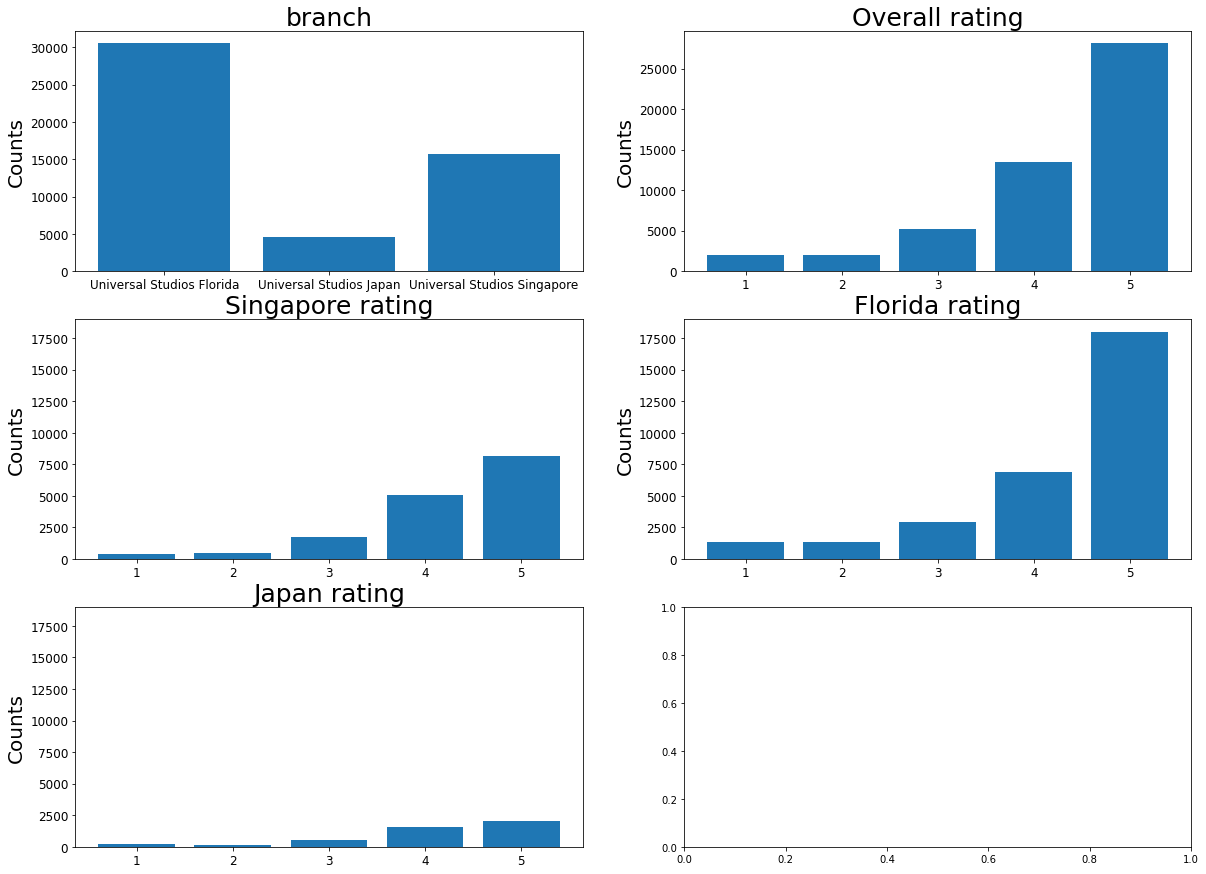

In [10]:
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 15)

# make subplots
fig, axes = plt.subplots(nrows = 3, ncols = 2)

# Get Data for parks
X_Survived = universal_df.groupby('branch').size().reset_index(name='Counts')['branch']
Y_Survived = universal_df.groupby('branch').size().reset_index(name='Counts')['Counts']
# Make bar plots
axes[0, 0].bar(X_Survived, Y_Survived)
axes[0, 0].set_title('branch', fontsize=25)
axes[0, 0].set_ylabel('Counts', fontsize=20)
axes[0, 0].tick_params(axis='both', labelsize=12)

# Get data for ratings
X_Survived = universal_df.groupby('rating').size().reset_index(name='Counts')['rating']
Y_Survived = universal_df.groupby('rating').size().reset_index(name='Counts')['Counts']
# Make bar plots
axes[0, 1].bar(X_Survived, Y_Survived)
axes[0, 1].set_title('Overall rating', fontsize=25)
axes[0, 1].set_ylabel('Counts', fontsize=20)
axes[0, 1].tick_params(axis='both', labelsize=12)

# Get data for ratings for 'Florida' branch
X_Survived = universal_df[universal_df['branch']=='Universal Studios Florida'].groupby('rating').size().reset_index(name='Counts')['rating']
Y_Survived = universal_df[universal_df['branch']=='Universal Studios Florida'].groupby('rating').size().reset_index(name='Counts')['Counts']

axes[1, 1].bar(X_Survived, Y_Survived)
axes[1, 1].set_title('Florida rating', fontsize=25)
axes[1, 1].set_ylabel('Counts', fontsize=20)
axes[1, 1].tick_params(axis='both', labelsize=12)
axes[1, 1].set_ylim(0,19000)

# Get data for ratings for 'Singapore' branch
X_Survived = universal_df[universal_df['branch']=='Universal Studios Singapore'].groupby('rating').size().reset_index(name='Counts')['rating']
Y_Survived = universal_df[universal_df['branch']=='Universal Studios Singapore'].groupby('rating').size().reset_index(name='Counts')['Counts']
# Make bar plots
axes[1, 0].bar(X_Survived, Y_Survived)
axes[1, 0].set_title('Singapore rating', fontsize=25)
axes[1, 0].set_ylabel('Counts', fontsize=20)
axes[1, 0].tick_params(axis='both', labelsize=12)
axes[1, 0].set_ylim(0,19000)

# Get data for ratings for 'Japan' branch
X_Survived = universal_df[universal_df['branch']=='Universal Studios Japan'].groupby('rating').size().reset_index(name='Counts')['rating']
Y_Survived = universal_df[universal_df['branch']=='Universal Studios Japan'].groupby('rating').size().reset_index(name='Counts')['Counts']
# Make bar plots
axes[2, 0].bar(X_Survived, Y_Survived)
axes[2, 0].set_title('Japan rating', fontsize=25)
axes[2, 0].set_ylabel('Counts', fontsize=20)
axes[2, 0].tick_params(axis='both', labelsize=12)
axes[2, 0].set_ylim(0,19000);

In [11]:
universal_df.isna().sum() # Check for missing data

rating          0
written_date    0
title           0
review_text     0
branch          0
dtype: int64

In [12]:
# Apply part of speech tags (not used for this analysis)
universal_df['tagged_review'] = universal_df['review_text'].apply(lambda x : pos_tag(word_tokenize(x))) 

In [13]:
def clean_text(text):
    # Clean text, remove end of lines, remove uppercase letters, puctuation and numbers.
    text = text.replace('\n','')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    r=re.compile(r'\d')
    text = r.sub('', text)
    text = text.strip()
    return text

def stringit(x):
    # Convert list of words to string
    y = " "
    
    return y.join(x)
def normalize_text(df, col, add_on= ''):
    # Clean, Tokenize, and stem text. Remove stopwords from text. Returns a cleaned column, a tokenized column, and a column of tokens as string
    df['clean_txt' + add_on] = df[col].apply(lambda x : clean_text(x))
    df['tokenized_txt' + add_on] = df['clean_txt' + add_on].apply(lambda x : word_tokenize(x))
    stopword = stopwords.words('english') # Set stopwords
    df['tokenized_txt' + add_on] = df['tokenized_txt' + add_on].apply(lambda x : [word for word in x if word not in stopword]) # Remove stopwords for each row
    porter = nltk.stem.PorterStemmer() # Create stemmer
    df['stemmed_txt' + add_on] = df['tokenized_txt' +add_on].apply(lambda x : [porter.stem(word) for word in x]) 
    df['stemmed_string' + add_on] = df['stemmed_txt' + add_on].apply(lambda x : stringit(x))

In [14]:
normalize_text(universal_df, 'review_text', add_on= '_review') # Apply normilization

In [15]:
universal_df.head() # View data frame with all added columns

,rating,written_date,title,review_text,branch,tagged_review,clean_txt_review,tokenized_txt_review,stemmed_txt_review,stemmed_string_review
0,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,"[(We, PRP), (went, VBD), (to, TO), (Universal,...",we went to universal over memorial day weekend...,"[went, universal, memorial, day, weekend, tota...","[went, univers, memori, day, weekend, total, t...",went univers memori day weekend total train wr...
1,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,"[(The, DT), (food, NN), (service, NN), (is, VB...",the food service is horrible i’m not reviewing...,"[food, service, horrible, ’, reviewing, food, ...","[food, servic, horribl, ’, review, food, ’, wa...",food servic horribl ’ review food ’ wait time ...
2,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,"[(I, PRP), (booked, VBD), (this, DT), (vacatio...",i booked this vacation mainly to ride hagrid m...,"[booked, vacation, mainly, ride, hagrid, motor...","[book, vacat, mainli, ride, hagrid, motorcycl,...",book vacat mainli ride hagrid motorcycl advent...
3,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,"[(When, WRB), (a, DT), (person, NN), (tries, V...",when a person tries the test seat for the ride...,"[person, tries, test, seat, rides, gets, green...","[person, tri, test, seat, ride, get, green, li...",person tri test seat ride get green light go l...
4,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,"[(Ok, NNP), (,, ,), (I, PRP), (ca, MD), (n't, ...",ok i cant stress enough to anyone and everyone...,"[ok, cant, stress, enough, anyone, everyone, g...","[ok, cant, stress, enough, anyon, everyon, go,...",ok cant stress enough anyon everyon go univers...


In [16]:
# Apply nltk sentiment analyzer to data frame and return a 1-5 rating score
sia = SentimentIntensityAnalyzer() # Set analyzer
universal_df['review_sentiment_compound'] = universal_df['review_text'].apply(lambda x : sia.polarity_scores(x)['compound']) # Analyze text and get compound score
def convert(n):
    # Convert returned result from -1 to 1 scale to standard 1-5 rating scale
    x = n + 3 + n  # Formula for converting scores
    return round(x)
universal_df['sentiment_rating'] = universal_df['review_sentiment_compound'].apply(lambda x : convert(x))

Accuracy:  0.5220769003835185
Precision: [0.38225256 0.14353839 0.20843672 0.27789256 0.62034967]
Recall:    [0.28455285 0.15179022 0.09647779 0.15944284 0.81737834]
F1 score:  [0.32624527 0.14754902 0.13190264 0.20262699 0.70536343]


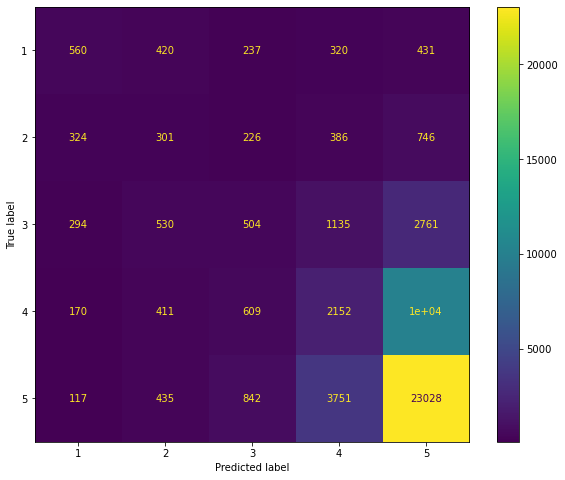

In [17]:
# Get accuracy and precision, recall and F1 scores
print('Accuracy: ',accuracy_score(universal_df['rating'], universal_df['sentiment_rating']))
score_list = precision_recall_fscore_support(universal_df['rating'], universal_df['sentiment_rating']) # Get precision, recall, and f1 scores
print('Precision:', score_list[0])
print('Recall:   ', score_list[1])
print('F1 score: ', score_list[2])
fig, ax = plt.subplots(figsize=(10,8))
# Create a confusion matrix of results
mat = ConfusionMatrixDisplay(confusion_matrix(universal_df['rating'], universal_df['sentiment_rating']),
                            display_labels=['1','2','3','4','5'])

mat.plot(ax=ax);

In [18]:
# Apply Keras model to predict score
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import scipy
from sklearn.model_selection import train_test_split

In [19]:
# Select sample cretae train, test split

X = universal_df['stemmed_string_review']
y = universal_df['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.5, random_state=11)

In [20]:
# Build Keras Classifier network
N_FEATURES = 5000 # Set number of features
N_CLASSES = 5 # Set number of classes

def build_network():
    # Compile a neural network
    nn = Sequential()
    nn.add(Dense(500, activation='relu', input_shape= (N_FEATURES,)))
    nn.add(Dense(150, activation= 'relu'))
    nn.add(Dense(N_CLASSES, activation= 'softmax'))
    nn.compile(
        loss= 'categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return nn

In [21]:
vectorizer = TfidfVectorizer( max_features= 5000) # Create vectorizer
tfidf_train = vectorizer.fit_transform(X_train) # Return features and tfidf values for training set
tfidf_train.sort_indices() # Sort by index (required by tensorflow)
tfidf_val = vectorizer.transform(X_val)  # Return tfidf values for test set
tfidf_val.sort_indices() # Sort by index (required by tensorflow)

In [22]:
# Create model
dnn =  KerasClassifier(build_fn= build_network,
                        epochs= 100,
                        batch_size=128,
                      verbose=True)
train_k = dnn.fit(tfidf_train, y_train) # Train model

confusion_matrix(y_val, dnn.predict(tfidf_val)) # Return confusion matrix of test set

Epoch 1/100


C:\Users\aarme\anaconda3.2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


199/199 [==============================] - 19s 42ms/step - loss: 1.1120 - accuracy: 0.5463
Epoch 2/100
199/199 [==============================] - 9s 44ms/step - loss: 0.7497 - accuracy: 0.6771
Epoch 3/100
199/199 [==============================] - 9s 44ms/step - loss: 0.5982 - accuracy: 0.7570
Epoch 4/100
199/199 [==============================] - 9s 44ms/step - loss: 0.3446 - accuracy: 0.8885
Epoch 5/100
199/199 [==============================] - 9s 44ms/step - loss: 0.1087 - accuracy: 0.9774
Epoch 6/100
199/199 [==============================] - 9s 44ms/step - loss: 0.0227 - accuracy: 0.9980
Epoch 7/100
199/199 [==============================] - 9s 44ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 8/100
199/199 [==============================] - 9s 45ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 9/100
199/199 [==============================] - 9s 44ms/step - loss: 0.0022 - accuracy: 0.9999
Epoch 10/100
199/199 [==============================] - 9s 45ms/step - loss: 0.0013 - accurac

C:\Users\aarme\anaconda3.2\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


199/199 [==============================] - 2s 8ms/step


array([[  424,   160,   206,    80,   135],
       [  247,   174,   325,   140,   125],
       [  177,   232,   792,   704,   635],
       [  103,   139,   813,  2117,  3506],
       [   63,    79,   485,  2533, 11029]], dtype=int64)

  8/199 [>.............................] - ETA: 1s

C:\Users\aarme\anaconda3.2\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


199/199 [==============================] - 2s 8ms/step
Accuracy:  0.5717657239507532
Precision: [0.41814596 0.22193878 0.30217474 0.37979907 0.71477641]
Recall:    [0.42189055 0.17210682 0.31181102 0.31701108 0.77729227]
F1 score:  [0.42000991 0.19387187 0.30691726 0.34557623 0.74472467]


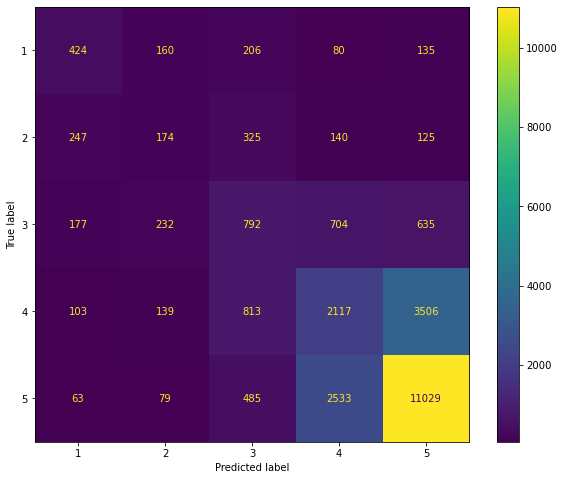

In [23]:
pred_test = dnn.predict(tfidf_val) # Apply model to test data
accuracy = accuracy_score(y_val, pred_test) # Get accuracy of model
score_list = precision_recall_fscore_support(y_val, pred_test) # Get precision, recall, and f1 scores
print('Accuracy: ',accuracy)
print('Precision:', score_list[0])
print('Recall:   ', score_list[1])
print('F1 score: ', score_list[2])
# Create confusion matrix for test results
mat = ConfusionMatrixDisplay(confusion_matrix(y_val, pred_test),
                            display_labels=['1','2','3','4','5'])
fig, ax = plt.subplots(figsize=(10,8))
mat.plot(ax=ax);

Count of tokens


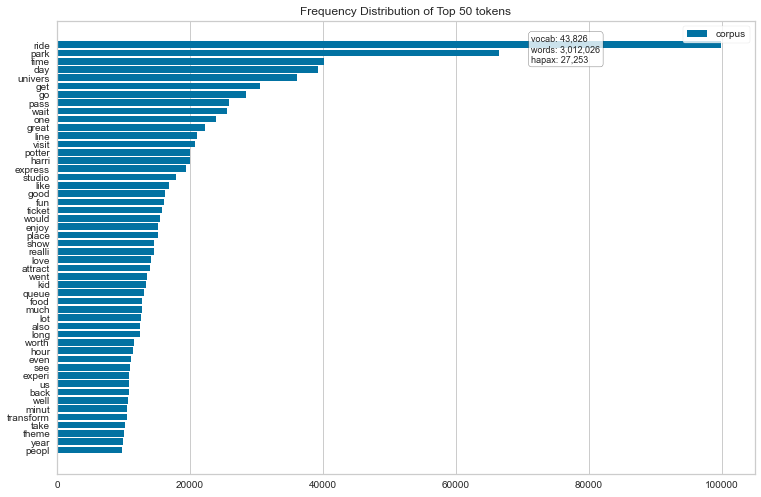

In [77]:
# Plot top 50 word tokens
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(universal_df['stemmed_string_review'])
features = vectorizer.get_feature_names()
print('Count of tokens')
visualizer = FreqDistVisualizer(features=features, size=(900, 600))
visualizer.fit(docs)
visualizer.poof();

tfidf values


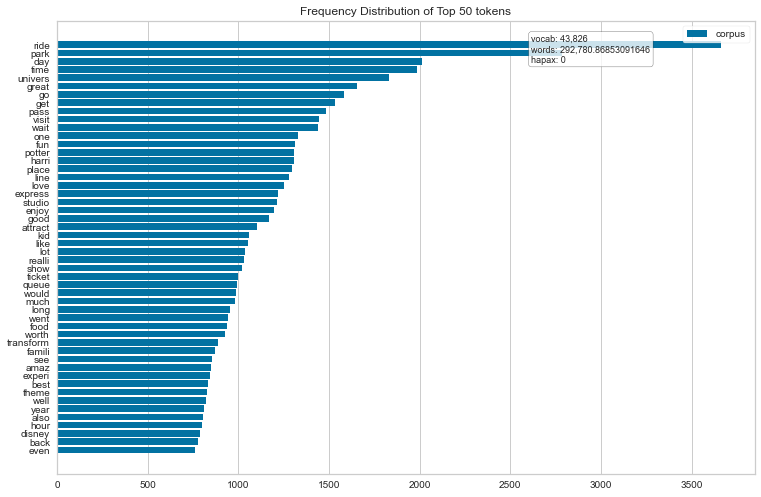

In [78]:
# Show to 50 words by tfidf scores
vectorizer = TfidfVectorizer()
docs = vectorizer.fit_transform(universal_df['stemmed_string_review'])
features = vectorizer.get_feature_names()
print('tfidf values')
visualizer = FreqDistVisualizer(features=features, size=(900, 600))
visualizer.fit(docs)
visualizer.poof();



Count of tokens


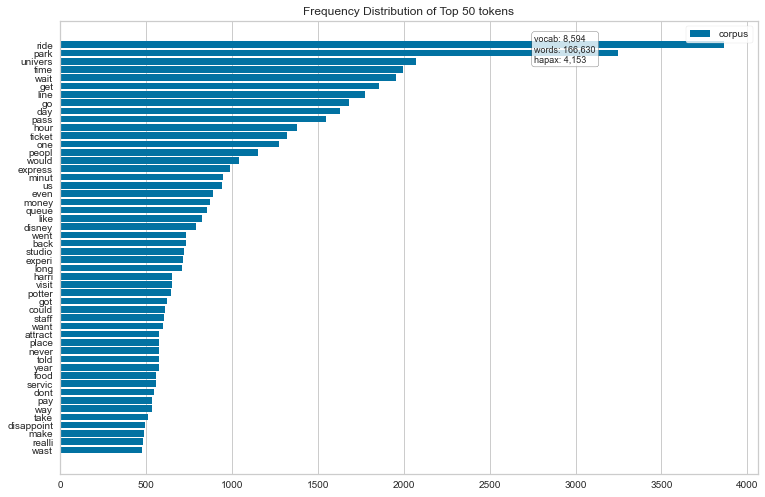

In [79]:
# Top 50 words  for reviews with a 1 rating
vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(universal_df[universal_df['rating']==1]['stemmed_string_review'])
features = vectorizer.get_feature_names()
print('Count of tokens')
visualizer = FreqDistVisualizer(features=features, size=(900, 600))
visualizer.fit(docs)
visualizer.poof();

In [111]:
# Create a dictionary of words with their tfidf scores 
vectorizer = TfidfVectorizer() # Create vectorizer
tfidf = vectorizer.fit_transform(universal_df['stemmed_string_review']) # Aplly vectorizer and get score
feature_names = vectorizer.get_feature_names() # Get words fro vectorizer
# Add words and score to dictionary
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]
    

In [113]:
# Get top 50 words
print(sorted(dic, key=dic.get, reverse= True)[:50])

['guest', 'servic', 'sneak', 'express', 'sent', 'line', 'jacki', 'smirk', 'wreck', 'pass', 'paid', 'forti', 'total', 'understaf', 'hour', 'sucker', 'work', 'took', 'convinc', 'bc', 'pay', 'apolog', 'patron', 'code', 'reopen', 'suck', 'prime', 'forev', 'park', 'still', 'worker', 'restroom', 'clearli', 'peopl', 'horribl', 'share', 'lane', 'also', 'memori', 'bar', 'nearli', 'disast', 'jump', 'long', 'app', 'yet', 'butter', 'happen', 'point', 'turn']


In [116]:
# Create a dictionary of words with their tfidf scores for ratings ==1 
tfidf = vectorizer.fit_transform(universal_df[universal_df['rating']==1]['stemmed_string_review'])
feature_names = vectorizer.get_feature_names()
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['regist', 'cashier', 'food', 'cash', 'minimum', 'ruin', 'horribl', 'review', 'whole', 'work', 'close', 'servic', 'place', 'experi', 'minut', 'one', 'get', 'wait', 'time', 'vacat', 'uncar', 'disrespect', 'rude', 'manag', 'camp', 'bubba', 'especi', 'restor', 'disrispectful', 'super', 'staff', 'long', 'there', 'go', 'vomit', 'like', 'smell', 'outdat', 'ride', 'ever', 'worst', 'less', 'great', 'capac', 'take', 'id', 'wont', 'guest', 'care', 'clearli']


In [117]:
# Create a dictionary of words with their tfidf scores for ratings == 2
tfidf = vectorizer.fit_transform(universal_df[universal_df['rating']==2]['stemmed_string_review'])
feature_names = vectorizer.get_feature_names()
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['sneak', 'guest', 'express', 'servic', 'sent', 'line', 'smirk', 'wreck', 'pass', 'jacki', 'forti', 'total', 'sucker', 'took', 'understaf', 'work', 'prime', 'bc', 'code', 'paid', 'hour', 'convinc', 'still', 'reopen', 'patron', 'apolog', 'share', 'park', 'bar', 'pay', 'restroom', 'lane', 'memori', 'forev', 'worker', 'also', 'suck', 'butter', 'app', 'clearli', 'disast', 'beer', 'jump', 'horribl', 'long', 'weekend', 'nearli', 'peopl', 'yet', 'avoid']


In [118]:
# Create a dictionary of words with their tfidf scores for ratings == 3
tfidf = vectorizer.fit_transform(universal_df[universal_df['rating']==3]['stemmed_string_review'])
feature_names = vectorizer.get_feature_names()
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['stink', 'sole', 'earli', 'connect', 'ripoff', 'specif', 'biggest', 'wizard', 'resort', 'twice', 'ever', 'gate', 'custom', 'couldnt', 'simul', 'go', 'servic', 'stay', 'overal', 'though', 'open', 'love', 'pay', 'two', 'world', 'park', 'could', 'theme', 'mani', 'fun', 'even', 'get', 'univers', 'ride', 'may', 'summertim', 'move', 'keep', 'thing', 'easier', 'much', 'would', 'app', 'access', 'made', 'ton', 'unorgan', 'conveni', 'extrem', 'everyth']


In [119]:
# Create a dictionary of words with their tfidf scores for ratings == 4
tfidf = vectorizer.fit_transform(universal_df[universal_df['rating']==4]['stemmed_string_review'])
feature_names = vectorizer.get_feature_names()
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['seat', 'rectifi', 'green', 'test', 'situat', 'oper', 'turn', 'light', 'group', 'cant', 'away', 'get', 'give', 'actual', 'person', 'say', 'tri', 'ride', 'long', 'express', 'line', 'pass', 'go', 'cost', 'extra', 'potter', 'harri', 'purchas', 'benefit', 'realli', 'perspect', 'quantiti', 'qualiti', 'staf', 'citywalk', 'accept', 'wasnt', 'sketchi', 'pay', 'save', 'doesnt', 'easi', 'vehicl', 'climb', 'final', 'later', 'nearli', 'continu', 'said', 'shrek']


In [120]:
# Create a dictionary of words with their tfidf scores for ratings = 5
tfidf = vectorizer.fit_transform(universal_df[universal_df['rating']==5]['stemmed_string_review'])
feature_names = vectorizer.get_feature_names()
dic = {}
for col in tfidf.nonzero()[1]:
    dic[feature_names[col]] = tfidf[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['bourn', 'stuntaculari', 'xs', 'jason', 'enough', 'stress', 'knew', 'wrong', 'worth', 'anyon', 'ok', 'noth', 'pack', 'wasnt', 'entir', 'cost', 'go', 'watch', 'absolut', 'cant', 'think', 'never', 'time', 'everyon', 'trip', 'movi', 'miss', 'orlando', 'sure', 'awesom', 'buy', 'everi', 'make', 'dont', 'take', 'see', 'would', 'went', 'amaz', 'wait', 'studio', 'pass', 'univers', 'expect', 'long', 'bit', 'enjoy', 'crowd', 'clean', 'impress']


In [121]:
# Create a dictionary of words with their frequency 
word_vect = CountVectorizer()
word_count = word_vect.fit_transform(universal_df['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])

['express', 'line', 'park', 'pass', 'guest', 'servic', 'hour', 'day', 'total', 'wait', 'get', 'paid', 'sent', 'took', 'also', 'ride', 'work', 'still', 'peopl', 'sneak', 'pay', 'long', 'went', 'univers', 'memori', 'weekend', 'train', 'wreck', 'lot', 'forti', 'minut', 'prime', 'make', 'wast', 'time', 'extra', 'ticket', 'turn', 'away', 'bc', 'app', 'show', 'bar', 'code', 'forev', 'clearli', 'understaf', 'yet', 'anoth', 'age']


In [122]:
# Create a dictionary of words with their frequency for ratings ==1 
word_count = word_vect.fit_transform(universal_df[universal_df['rating']==1]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['food', 'servic', 'horribl', 'review', 'wait', 'time', 'minut', 'minimum', 'get', 'one', 'cashier', 'work', 'place', 'ruin', 'whole', 'experi', 'close', 'cash', 'regist', 'worst', 'ever', 'ride', 'outdat', 'smell', 'like', 'vomit', 'go', 'there', 'long', 'staff', 'super', 'disrispectful', 'restor', 'especi', 'bubba', 'camp', 'manag', 'rude', 'disrespect', 'uncar', 'vacat', 'univers', 'thing', 'disney', 'everyth', 'well', 'due', 'poorli', 'arriv', 'open']


In [123]:
# Create a dictionary of words with their frequency for ratings = 2
word_count = word_vect.fit_transform(universal_df[universal_df['rating']==2]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['express', 'line', 'park', 'pass', 'guest', 'servic', 'hour', 'day', 'total', 'wait', 'get', 'paid', 'sent', 'took', 'also', 'ride', 'work', 'still', 'peopl', 'sneak', 'pay', 'long', 'went', 'univers', 'memori', 'weekend', 'train', 'wreck', 'lot', 'forti', 'minut', 'prime', 'make', 'wast', 'time', 'extra', 'ticket', 'turn', 'away', 'bc', 'app', 'show', 'bar', 'code', 'forev', 'clearli', 'understaf', 'yet', 'anoth', 'age']


In [124]:
word_count = word_vect.fit_transform(universal_df[universal_df['rating']==3]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['earli', 'go', 'park', 'mani', 'fun', 'simul', 'ride', 'love', 'wizard', 'world', 'overal', 'custom', 'servic', 'stink', 'specif', 'couldnt', 'get', 'gate', 'open', 'even', 'though', 'stay', 'univers', 'resort', 'sole', 'could', 'pay', 'twice', 'two', 'connect', 'biggest', 'theme', 'ripoff', 'ever', 'first', 'inform', 'given', 'guest', 'phone', 'inaccur', 'dine', 'plan', 'good', 'within', 'accord', 'staff', 'member', 'refil', 'cup', 'well']


In [125]:
word_count = word_vect.fit_transform(universal_df[universal_df['rating']==4]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['seat', 'ride', 'get', 'person', 'tri', 'test', 'green', 'light', 'go', 'long', 'line', 'turn', 'away', 'oper', 'say', 'cant', 'actual', 'give', 'express', 'pass', 'group', 'rectifi', 'situat', 'spent', 'night', 'site', 'sapphir', 'fall', 'famili', 'adult', 'kid', 'age', 'day', 'park', 'hopper', 'want', 'arent', 'four', 'dont', 'know', 'would', 'experi', 'without', 'earli', 'admiss', 'didnt', 'much', 'univers', 'studio', 'offer']


In [126]:
# Create a dictionary of words with their frequency for ratings = 5
word_count = word_vect.fit_transform(universal_df[universal_df['rating']==5]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['enough', 'go', 'time', 'bourn', 'worth', 'ok', 'cant', 'stress', 'anyon', 'everyon', 'univers', 'studio', 'orlando', 'make', 'sure', 'take', 'see', 'stuntaculari', 'watch', 'xs', 'wasnt', 'never', 'knew', 'jason', 'buy', 'movi', 'absolut', 'awesom', 'amaz', 'entir', 'cost', 'trip', 'wait', 'everi', 'went', 'pack', 'would', 'pass', 'think', 'noth', 'wrong', 'dont', 'miss', 'adventur', 'park', 'best', 'two', 'impress', 'clean', 'crowd']


In [128]:
# Create a dictionary of words with their frequency for Florida branch
word_count = word_vect.fit_transform(universal_df[universal_df['branch']=='Universal Studios Florida']['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['express', 'line', 'park', 'pass', 'guest', 'servic', 'hour', 'day', 'total', 'wait', 'get', 'paid', 'sent', 'took', 'also', 'ride', 'work', 'still', 'peopl', 'sneak', 'pay', 'long', 'went', 'univers', 'memori', 'weekend', 'train', 'wreck', 'lot', 'forti', 'minut', 'prime', 'make', 'wast', 'time', 'extra', 'ticket', 'turn', 'away', 'bc', 'app', 'show', 'bar', 'code', 'forev', 'clearli', 'understaf', 'yet', 'anoth', 'age']


In [129]:
# Create a dictionary of words with their frequency for Singapore branch
word_count = word_vect.fit_transform(universal_df[universal_df['branch']=='Universal Studios Singapore']['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['place', 'awesom', 'ride', 'intrigu', 'fill', 'thrill', 'adventur', 'even', 'small', 'show', 'fantast', 'excel', 'plan', 'go', 'vacat', 'famili', 'friend', 'want', 'make', 'trip', 'excit', 'spontan', 'lot', 'activ', 'univers', 'studio', 'singapor', 'open', 'part', 'resort', 'world', 'sentosa', 'complex', 'island', 'love', 'theme', 'zone', 'attract', 'shop', 'eat', 'establish', 'street', 'entertain', 'perform', 'live', 'movi', 'charact', 'avail', 'park', 'favorit']


In [130]:
# Create a dictionary of words with their frequency for Japan branch
word_count = word_vect.fit_transform(universal_df[universal_df['branch']=='Universal Studios Japan']['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['japan', 'architectur', 'tokyo', 'bring', '日本是一個藝術的國家之一', '東京到大阪建築文物帶出了日本的風格寺廟方面較為熱門重點壯觀美麗外表', '奪目金色還有不同寺廟也帶出各有特色城市建築較為規律也帶出繁華日本另一面', '東京日本各有特色美食非常吸引難忘的回憶個人意見提供參考starchan', 'one', 'countri', 'art', 'relic', 'osaka', 'japanes', 'style', 'local', 'aspect', 'focus', 'beauti', 'appear', 'dazzl', 'gold', 'differ', 'also', 'distinct', 'urban', 'regular', 'prosper', 'side', 'uniqu', 'cuisin', 'attract', 'unforgett', 'memori', 'person', 'opinion', 'provid', 'refer', 'starchan', 'expens', 'noth', 'special', 'throw', 'rubbish', 'bentou', 'buy', 'food', 'park', 'crazi', 'love']


In [134]:
# Create a dictionary of words with their frequency for Florida branch with low rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Florida') & (universal_df['rating']<=2)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['express', 'line', 'park', 'pass', 'guest', 'servic', 'hour', 'day', 'total', 'wait', 'get', 'paid', 'sent', 'took', 'also', 'ride', 'work', 'still', 'peopl', 'sneak', 'pay', 'long', 'went', 'univers', 'memori', 'weekend', 'train', 'wreck', 'lot', 'forti', 'minut', 'prime', 'make', 'wast', 'time', 'extra', 'ticket', 'turn', 'away', 'bc', 'app', 'show', 'bar', 'code', 'forev', 'clearli', 'understaf', 'yet', 'anoth', 'age']


In [138]:
# Create a dictionary of words with their frequency for Florida branch with medium rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Florida') & (universal_df['rating']==3)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['earli', 'go', 'park', 'mani', 'fun', 'simul', 'ride', 'love', 'wizard', 'world', 'overal', 'custom', 'servic', 'stink', 'specif', 'couldnt', 'get', 'gate', 'open', 'even', 'though', 'stay', 'univers', 'resort', 'sole', 'could', 'pay', 'twice', 'two', 'connect', 'biggest', 'theme', 'ripoff', 'ever', 'first', 'inform', 'given', 'guest', 'phone', 'inaccur', 'dine', 'plan', 'good', 'within', 'accord', 'staff', 'member', 'refil', 'cup', 'well']


In [137]:
# Create a dictionary of words with their frequency for Florida branch with high rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Florida') & (universal_df['rating']>=4)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['seat', 'ride', 'get', 'person', 'tri', 'test', 'green', 'light', 'go', 'long', 'line', 'turn', 'away', 'oper', 'say', 'cant', 'actual', 'give', 'express', 'pass', 'group', 'rectifi', 'situat', 'ok', 'stress', 'enough', 'anyon', 'everyon', 'univers', 'studio', 'orlando', 'make', 'sure', 'take', 'time', 'see', 'bourn', 'stuntaculari', 'watch', 'xs', 'wasnt', 'never', 'knew', 'jason', 'buy', 'movi', 'absolut', 'awesom', 'amaz', 'worth']


In [139]:
# Create a dictionary of words with their frequency for Singapore branch with low rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Singapore') & (universal_df['rating']<=2)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['wait', 'attract', 'estim', 'time', 'ride', 'mani', 'close', 'still', 'full', 'price', 'inform', 'book', 'dont', 'think', 'function', 'differ', 'correct', 'covid', 'everi', 'second', 'row', 'seat', 'left', 'unus', 'doubl', 'end', 'hour', 'last', 'mayb', 'minut', 'nonholiday', 'friday', 'start', 'pm', 'min', 'mean', 'gon', 'na', 'spend', 'line', 'worth', 'food', 'terribl', 'overpr', 'rain', 'visit', 'pretti', 'sure', 'never', 'ever']


In [140]:
# Create a dictionary of words with their frequency for Singapore branch with medium rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Singapore') & (universal_df['rating']==3)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['umm', 'total', 'understand', 'lot', 'limit', 'period', 'howev', 'realli', 'recommend', 'famili', 'kid', 'year', 'old', 'noth', 'much', 'child', 'take', 'visit', 'day', 'pre', 'book', 'ticket', 'luckili', 'line', 'long', 'entri', 'smaller', 'expect', 'price', 'unexpect', 'love', 'nevertheless', 'roller', 'coaster', 'fearsom', 'ride', 'young', 'peopl', 'would', 'made', 'children', 'cri', 'fear', 'restrict', 'pandem', 'mani', 'shop', 'close', 'gener', 'disappoint']


In [141]:
# Create a dictionary of words with their frequency for Singapore branch with high rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Singapore') & (universal_df['rating']>=4)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['place', 'awesom', 'ride', 'intrigu', 'fill', 'thrill', 'adventur', 'even', 'small', 'show', 'fantast', 'excel', 'plan', 'go', 'vacat', 'famili', 'friend', 'want', 'make', 'trip', 'excit', 'spontan', 'lot', 'activ', 'univers', 'studio', 'singapor', 'open', 'part', 'resort', 'world', 'sentosa', 'complex', 'island', 'love', 'theme', 'zone', 'attract', 'shop', 'eat', 'establish', 'street', 'entertain', 'perform', 'live', 'movi', 'charact', 'avail', 'park', 'favorit']


In [142]:
# Create a dictionary of words with their frequency for Japan branch with low rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Japan') & (universal_df['rating']<=2)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['expens', 'noth', 'special', 'throw', 'rubbish', 'bentou', 'buy', 'food', 'park', 'crazi', 'know', 'incred', 'annoy', 'japanes', 'peopl', 'get', 'come', 'dumbl', 'appli', 'rule', 'read', 'care', 'english', 'day', 'go', 'avoid', 'problem', 'ala', 'still', 'manag', 'find', 'someth', 'nitpick', 'bag', 'bottl', 'water', 'appar', 'overs', 'joke', 'took', 'thank', 'got', 'heatstrok', 'contact', 'custom', 'servic', 'dont', 'great', 'never', 'osaka']


In [143]:
# Create a dictionary of words with their frequency for Japan branch with medium rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Japan') & (universal_df['rating']==3)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['time', 'kid', 'park', 'ride', 'almost', 'rain', 'close', 'great', 'due', 'pm', 'bit', 'area', 'look', 'magic', 'wand', 'queue', 'mani', 'year', 'min', 'fair', 'catch', 'miss', 'even', 'though', 'also', 'around', 'line', 'need', 'japan', 'entri', 'visit', 'land', 'amaz', 'definit', 'show', 'wast', 'price', 'long', 'small', 'sesam', 'st', 'movi', 'get', 'disappoint', 'charact', 'hour', 'disneyland', 'univers', 'crappi', 'disney']


In [144]:
# Create a dictionary of words with their frequency for Japan branch with high rating
word_count = word_vect.fit_transform(universal_df[(universal_df['branch']=='Universal Studios Japan') & (universal_df['rating']>=4)]['stemmed_string_review'])
feature_names = word_vect.get_feature_names()
dic = {}
for col in word_count.nonzero()[1]:
    dic[feature_names[col]] = word_count[0, col]

print(sorted(dic, key=dic.get, reverse= True)[:50])


['japan', 'architectur', 'tokyo', 'bring', '日本是一個藝術的國家之一', '東京到大阪建築文物帶出了日本的風格寺廟方面較為熱門重點壯觀美麗外表', '奪目金色還有不同寺廟也帶出各有特色城市建築較為規律也帶出繁華日本另一面', '東京日本各有特色美食非常吸引難忘的回憶個人意見提供參考starchan', 'one', 'countri', 'art', 'relic', 'osaka', 'japanes', 'style', 'local', 'aspect', 'focus', 'beauti', 'appear', 'dazzl', 'gold', 'differ', 'also', 'distinct', 'urban', 'regular', 'prosper', 'side', 'uniqu', 'cuisin', 'attract', 'unforgett', 'memori', 'person', 'opinion', 'provid', 'refer', 'starchan', 'love', 'usj', 'there', 'someth', 'park', 'staff', 'kind', 'merchandis', 'quit', 'locat', 'recommend']
